In [1]:
%reload_ext autoreload
#!pip install -r requirements.txt

sin1 freq:[1, 3], phase:[-1.5707963267948966, 0]
sin2 freq:[4, 6], phase:[0, 1.5707963267948966]
sin1 freq:[1, 3], phase:[-1.5707963267948966, 0]
sin2 freq:[4, 6], phase:[0, 1.5707963267948966]
10
torch.Size([50, 3])


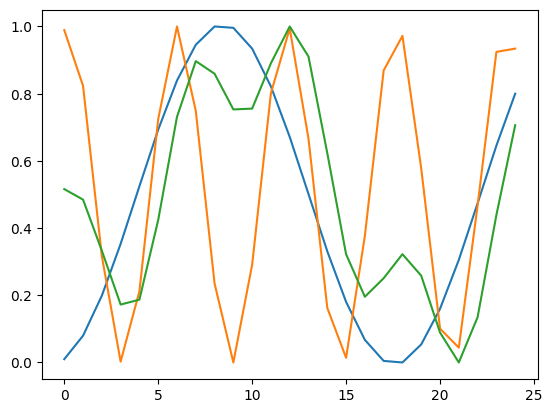

In [2]:
%autoreload
from architectures import COTGAN
from utils import DatasetSinus
from trainer import cotgan_trainer
import numpy as np
import torch
import matplotlib.pyplot as plt

seed = 42
alpha = 0.7
noise = 0
np.random.seed(seed)

trainset = DatasetSinus(num=6*2*24, seq_len=25, alpha=alpha, noise=noise)
testset = DatasetSinus(num=10, seq_len=50, alpha=alpha, noise=noise)

print(len(testset))
print(testset[0][0].size())

plt.plot(trainset[1][0]);

In [3]:
%autoreload
import neptune.new as neptune

run = neptune.init_run(
    project="kohmann/COTGAN",
    name="cotgan",
    tags=["testing"],
    description="",
    source_files=["architecture.py"],
    capture_hardware_metrics=False,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
)

device = "cuda" if torch.cuda.is_available() else "cpu"

params = {
    "model_name": "model_cotgan.pt",
    "n_epochs": 500,
    "l_rate": 0.001, # for both D and G
    "batch_size": 6,
    #"dis_rnn_num_layers": 2,
    #"dis_rnn_hidden_dim": 20,
    "gen_rnn_num_layers": 1,
    "gen_rnn_hidden_dim": 20,
    "hidden_dim": 64, #
    "scaling_coef": 1.0, # distance scaling (TODO(Not implemented))
    "sinkhorn_eps": 0.5, # epsilon regularizer
    "sinkhorn_l": 100, # sinkhorn calculation iterations
    "reg_lam": 0.1, # martingale penalty coefficient
    "Z_dim": 100,
    "optimizer": "Adam", # RMSprop, Adam
    "beta1": 0.5,
    "beta2": 0.9,
    "dataset": "sines",
    "feature_dim": trainset[0][0].size(1),
    "max_seq_len": trainset[0][0].size(0),
    "trainset_size": len(trainset),
    "testset_size": len(testset),
    "device": device,
}

run["parameters"] = params
run["dataset"] = {"alpha":alpha, "noise":noise,
                  "s1_freq": trainset.s1_freq, "s1_phase": trainset.s1_phase,
                  "s2_freq": trainset.s2_freq, "s2_phase": trainset.s2_phase}
#run.stop()
model = COTGAN(params)

cotgan_trainer(model, trainset, params, val_dataset=testset, neptune_logger=run, continue_training=False)
run.stop()

https://app.neptune.ai/kohmann/COTGAN/e/COT-48
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.9/site-packages/neptune/new/handler.py:168: NeptuneDeprecationWarning: The object you're logging will be implicitly cast to a string. We'll end support of this behavior in `neptune-client==1.0.0`. To log the object as a string, use `str(object)` instead.
  self._container.define(self._path, value, wait)
Epoch: 499, G: 5.5644, D: 5.1555: 100%|██████████| 500/500 [27:50<00:00,  3.34s/it]  

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 11 operations to synchronize with Neptune. Do not kill this process.


All 11 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/COTGAN/e/COT-48



# Generate random synthetic data
gen_z = rtsgan_generator(model, params)


log_visualizations(testset, gen_z, run) # logs pca, tsne, umap, mode_collapse
run["model_checkpoint"].upload(params["model_name"])

from metrics import compare_sin3_generation, sw_approx
np.random.seed(41)
testset2 = DatasetSinus(num=1000, seq_len=100, alpha=alpha, noise=noise)
params["testset_size"] = 1000
fake_data = rtsgan_generator(model, params)

mse_error = compare_sin3_generation(fake_data, alpha, noise)
print(f"MSE Error: {mse_error:.5f}")
x = torch.tensor(fake_data)
y = testset[:][0]
y_2 = testset2[:][0]
#wass_dist = sinkhorn_distance(x,y)
#mmd = MMD(x,y)
sw_baseline = sw_approx(y,y_2)
sw = sw_approx(y,x)

run["numeric_results/num_test_samples"] = len(testset)
run["numeric_results/sin3_generation_MSE_loss"] = mse_error
run["numeric_results/SW"] = sw.item()
run["numeric_results/SW_baseline"] = sw_baseline.item()

run.stop()